# Playing with Normalizing Flows

## Imports

In [1]:
import torch
from flows import RadialFlow, PlanarFlow
from tqdm import tqdm
import torch.nn.functional as F
from models import FCNEncoder, FCNDecoder, FlowModel
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import numpy as np

%load_ext autoreload
%autoreload 2

## Unit tests

In [7]:
layer = PlanarFlow(5)

In [8]:
z = torch.FloatTensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
f, log_det = layer(z)
print(f)
print(log_det)

tensor([[0.9224, 1.6608, 2.0363, 3.8097, 6.1633],
        [6.1066, 7.4661, 9.3244, 9.2614, 8.4013]], grad_fn=<AddBackward0>)
tensor([9.3409e-01, 1.2707e-04], grad_fn=<LogBackward>)


## Data

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [10]:
ds = tfds.load('binarized_mnist', split='train', shuffle_files=True)

In [11]:
len(ds)

50000

In [38]:
np_images = []

for example in tqdm(ds, total=len(ds)):
    image = example["image"]
    np_images.append(image.numpy().reshape(1, 28, 28))
    
np_images = np.concatenate(np_images, axis=0)

100%|██████████| 50000/50000 [00:04<00:00, 10966.68it/s]


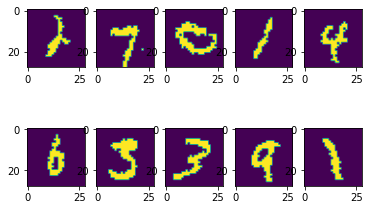

In [46]:
fig, axs = plt.subplots(2, 5)

for i in range(10):
    axs[i // 5, i % 5].imshow(np_images[i])

In [12]:
np.save('bin_mnist.npy', np_images)

NameError: name 'np_images' is not defined

In [13]:
from datasets import BinarizedMNIST

In [14]:
#mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
mnist_data = BinarizedMNIST('datasets/bin_mnist.npy')
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

## Model

In [33]:
D = 40

encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=28*28)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 784], dim_input=40)

In [34]:
loss_fn = BCEWithLogitsLoss()

for X_batch in data_loader:
    out = encoder(X_batch.view(-1, 784).float())
    mu, log_sigma = out[:, :40], out[:, 40:]
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    
    
#     tmp = x_hat.clone().detach().view(28, 28).numpy()
#     for i in range(28):
#         for j in range(28):
#             print(logsumexp([0, tmp[i, j]]), end=' ')
#         print()
    
    print()
#     for i in range(28):
#         for j in range(28):
#             print(X_batch[i, j], end=' ')
#         print()
            
    
    loss = log_prob_z0 + loss_fn(x_hat, X_batch.view(-1, 784).float()) - log_prob_zk - log_det
    print(log_prob_z0, loss_fn(x_hat, X_batch.view(-1, 784).float()), log_prob_zk, log_det, sep='\n')
    #print(loss_fn(x_hat, X_batch.view(-1, 784).float()))
    print()
    print(loss)

    break


tensor([-55.8113], grad_fn=<SumBackward1>)
tensor(0.7439, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor([-207.1264], grad_fn=<SumBackward1>)
tensor([-0.0081], grad_fn=<AddBackward0>)

tensor([152.0672], grad_fn=<SubBackward0>)


In [29]:
print(logsumexp([1, 2]))

2.313261687518223
